#### 必要なライブラリのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import japanize_matplotlib
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from tqdm.notebook import tqdm


#### 共通関数のインポート
著者が学習用、予測用、学習用ログ解析用、図示用の関数を用意してくださっているのでそちらを利用する

In [2]:
!git clone https://github.com/makaishi2/pythonlibs.git

from pythonlibs.torch_lib1 import *

fatal: destination path 'pythonlibs' already exists and is not an empty directory.


#### GPUの確認

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### データの準備

In [4]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
from io import BytesIO

# Define a custom transform to upscale images
class UpscaleTransform:
    def __init__(self, scale_factor):
        self.scale_factor = scale_factor

    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            # If img is a tensor, convert it to PIL image
            img = transforms.ToPILImage()(img)

        # Convert PIL image to tensor
        img_tensor = transforms.ToTensor()(img).unsqueeze(0)
        
        # Calculate the new size
        new_size = [int(d * self.scale_factor) for d in img_tensor.shape[2:]]
        
        # Upsample the image
        img_tensor = F.interpolate(img_tensor, size=new_size, mode='bilinear', align_corners=False)
        
        # Convert tensor back to PIL image
        img = transforms.ToPILImage()(img_tensor.squeeze(0))
        return img


# Define transformations including upscaling

scale_factor=1.3

transform_train = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=15),   # Randomly rotate the image
    transforms.Lambda(lambda x: UpscaleTransform(scale_factor)(x)),  # Upscale the image
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize the image
])
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)  # Randomly erase part of the image

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize the image
])

# Define datasets
train_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/test', transform=transform)
val_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/val_reorganized', transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Train loader has {len(train_loader.dataset)} images.")
print(f"Test loader has {len(test_loader.dataset)} images.")
print(f"Validation loader has {len(val_loader.dataset)} images.")


Train loader has 100000 images.
Test loader has 10000 images.
Validation loader has 10000 images.


#### Data Augmentation

#### CNNドロップアウト

In [12]:
class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))  # 64x64x3 → 64x64x32
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))  # 64x64x32 → 64x64x32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))  # 32x32x32 → 32x32x64
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))  # 32x32x64 → 32x32x64
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1)) # 16x16x64 → 16x16x128
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1)) # 16x16x128 → 16x16x128
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(524288, 128)  # 8x8x128 → 8192
        self.l2 = nn.Linear(128, 200)  # 128 → 200
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3
    
    def save_checkpoint(cls, epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

    @classmethod
    def load_checkpoint(cls, path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

In [ ]:
import numpy as np
import torch
import random

# 乱数の固定化
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# モデルインスタンス生成
net = CNN_v3(200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# 訓練と検証
num_epochs = 25
history15 = np.zeros((0, 5))
history15 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history15)

# 評価履歴の表示
evaluate_history(history15)

# チェックポイントの保存
net.save_checkpoint(num_epochs, net, optimizer, history15)

# Resnet構造

In [5]:
import torch
import torch.nn as nn
import os

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=200):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


    def save_checkpoint(cls, epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

    @classmethod
    def load_checkpoint(cls, path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

# Usage
model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200)


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [1/20], loss: 4.77383 acc: 0.04917 val_loss: 4.60228, val_acc: 0.08600


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [2/20], loss: 3.96812 acc: 0.14188 val_loss: 3.82308, val_acc: 0.17050


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [3/20], loss: 3.42387 acc: 0.22765 val_loss: 3.55467, val_acc: 0.22450


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [4/20], loss: 3.04661 acc: 0.29709 val_loss: 3.13624, val_acc: 0.29450


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [5/20], loss: 2.77082 acc: 0.34866 val_loss: 2.91926, val_acc: 0.33430


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [6/20], loss: 2.54222 acc: 0.39639 val_loss: 2.82764, val_acc: 0.36040


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [7/20], loss: 2.36046 acc: 0.43255 val_loss: 2.91551, val_acc: 0.35870


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [8/20], loss: 2.20563 acc: 0.46444 val_loss: 2.54675, val_acc: 0.41830


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [9/20], loss: 2.06255 acc: 0.49429 val_loss: 2.53575, val_acc: 0.42340


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [10/20], loss: 1.93929 acc: 0.52054 val_loss: 2.48396, val_acc: 0.43660


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [11/20], loss: 1.82711 acc: 0.54477 val_loss: 2.50507, val_acc: 0.44070


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [12/20], loss: 1.72102 acc: 0.56733 val_loss: 2.37924, val_acc: 0.45840


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [13/20], loss: 1.62206 acc: 0.58951 val_loss: 2.40448, val_acc: 0.46460


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [14/20], loss: 1.52549 acc: 0.60973 val_loss: 2.51894, val_acc: 0.45550


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [15/20], loss: 1.43389 acc: 0.63017 val_loss: 2.46787, val_acc: 0.46540


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [16/20], loss: 1.34734 acc: 0.64751 val_loss: 2.46776, val_acc: 0.48240


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [17/20], loss: 1.26573 acc: 0.66882 val_loss: 2.42379, val_acc: 0.48430


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [18/20], loss: 1.18515 acc: 0.68591 val_loss: 2.67087, val_acc: 0.46350


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [19/20], loss: 1.10594 acc: 0.70429 val_loss: 2.73064, val_acc: 0.46770


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [20/20], loss: 1.02849 acc: 0.72258 val_loss: 2.69181, val_acc: 0.47750
初期状態: 損失: 4.60228 精度: 0.08600
最終状態: 損失: 2.69181 精度: 0.47750


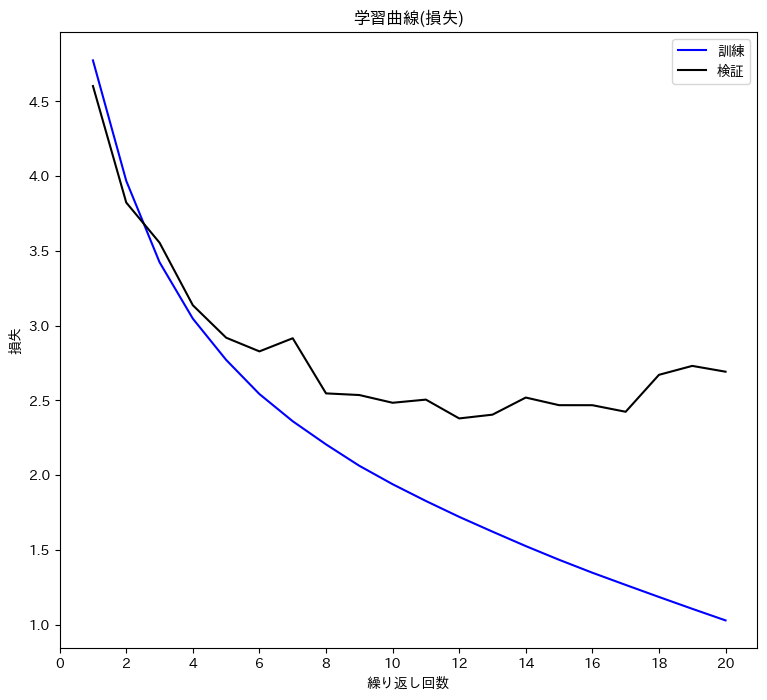

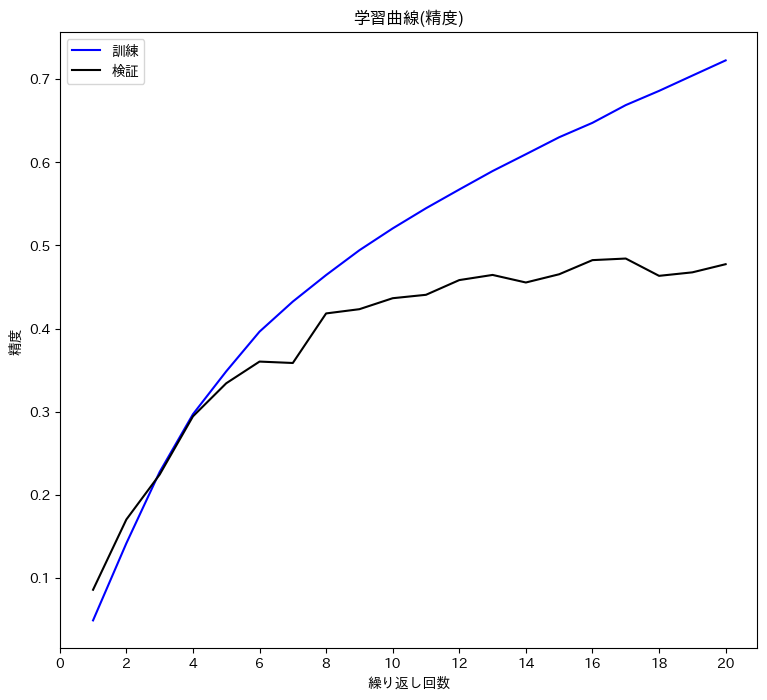

In [6]:
import numpy as np
import torch
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import torch.optim as optim
import numpy as np

# 乱数の固定化
seed_everything()

# モデルインスタンス生成
net = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 訓練と検証
num_epochs = 20
history21 = np.zeros((0, 5))
history21 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history21)

# 評価履歴の表示
evaluate_history(history21)

# チェックポイントの保存
net.save_checkpoint(num_epochs, net, optimizer, history21)


過学習を防ぐため、dropoutを増加する

In [7]:
import torch
import torch.nn as nn
import os

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)  # Apply dropout
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=200, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(dropout_rate) 
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_rate=dropout_rate)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_rate=0.5):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_rate))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, dropout_rate=dropout_rate))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def save_checkpoint(cls, epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

   
    def load_checkpoint(cls, path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

# Usage
model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200)


In [8]:
import numpy as np
import torch
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import torch.optim as optim
import numpy as np

# 乱数の固定化
seed_everything()

# モデルインスタンス生成
net = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 訓練と検証
num_epochs = 20
history21 = np.zeros((0, 5))
history21 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history21)

# 評価履歴の表示
evaluate_history(history21)

# チェックポイントの保存
net.save_checkpoint(num_epochs, net, optimizer, history21)


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [1/20], loss: 4.71829 acc: 0.05295 val_loss: 4.32863, val_acc: 0.09120


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [2/20], loss: 3.91463 acc: 0.14483 val_loss: 3.96670, val_acc: 0.14940


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [3/20], loss: 3.42576 acc: 0.22488 val_loss: 3.60697, val_acc: 0.21390


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [4/20], loss: 3.06883 acc: 0.28888 val_loss: 3.43913, val_acc: 0.24880


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [5/20], loss: 2.81003 acc: 0.33978 val_loss: 3.11155, val_acc: 0.30320


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [6/20], loss: 2.60548 acc: 0.38063 val_loss: 2.99772, val_acc: 0.33210


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [7/20], loss: 2.43564 acc: 0.41478 val_loss: 3.05595, val_acc: 0.33220


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [8/20], loss: 2.29793 acc: 0.44328 val_loss: 2.72083, val_acc: 0.38620


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [9/20], loss: 2.16905 acc: 0.46985 val_loss: 2.67325, val_acc: 0.39480


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [10/20], loss: 2.05719 acc: 0.49267 val_loss: 2.67519, val_acc: 0.39730


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [11/20], loss: 1.96198 acc: 0.51373 val_loss: 2.74492, val_acc: 0.39430


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [12/20], loss: 1.87114 acc: 0.53269 val_loss: 2.56971, val_acc: 0.42260


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [13/20], loss: 1.78657 acc: 0.55084 val_loss: 2.59089, val_acc: 0.43560


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [14/20], loss: 1.70360 acc: 0.56857 val_loss: 2.67319, val_acc: 0.42460


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch [15/20], loss: 1.62890 acc: 0.58508 val_loss: 2.51316, val_acc: 0.45360


  0%|          | 0/3125 [00:00<?, ?it/s]